In [1]:
import sys
import itertools
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker
import mplhep as hep
plt.style.use(hep.style.CMS)
import hist
from scipy.signal import savgol_filter
from scipy.stats import gaussian_kde

sys.path.append("..")
from HistogramLib.histogram import HistogramKind
from HistogramLib.store import HistogramStore
from hists.parameters import beamEnergies
from hists.store import HistogramId

%load_ext autoreload
%autoreload 1
%aimport longitudinalProfile.violin
from longitudinalProfile.violin import makeViolinBeamEnergy, makeViolinBeamEnergyDataSim

In [2]:
hist_folder = '/grid_mnt/data_cms_upgrade/cuisset/testbeam18/clue3d/v41'
#clueParams = "single-file"
clueParams = "cmssw"
histStore = HistogramStore(hist_folder, HistogramId)
datatypeToLegendMap = {"data":"Data"}

In [3]:
def getHist(datatype, beamEnergies, level="clue3d"):
    if level == "clue3d":
        return {beamEnergy : histStore
            .get(HistogramId("Clus3DClusteredEnergyPerLayer", clueParams, datatype))
            .getHistogram(HistogramKind.PROFILE)
            [{
                "mainOrAllTracksters" : hist.loc("mainTrackster"),
                # Project on clus3D_size
                "beamEnergy" : hist.loc(beamEnergy)
            }]
            .project("clus2D_layer")
            for beamEnergy in beamEnergies
        }
    elif level == "rechits":
        return {beamEnergy : histStore
            .get(HistogramId("RechitsEnergyReconstructedPerLayer", clueParams, datatype))
            .getHistogram(HistogramKind.PROFILE)
            [{
                "beamEnergy" : hist.loc(beamEnergy)
            }]
            for beamEnergy in beamEnergies
        }
    else:
        raise ValueError()

In [4]:
def makeViolinBeamEnergy_wrapper(datatype:str, beamEnergies=beamEnergies):
    hists = getHist(datatype, beamEnergies)
    makeViolinBeamEnergy(hists, datatype)
    plt.xlim(0, 29)
    

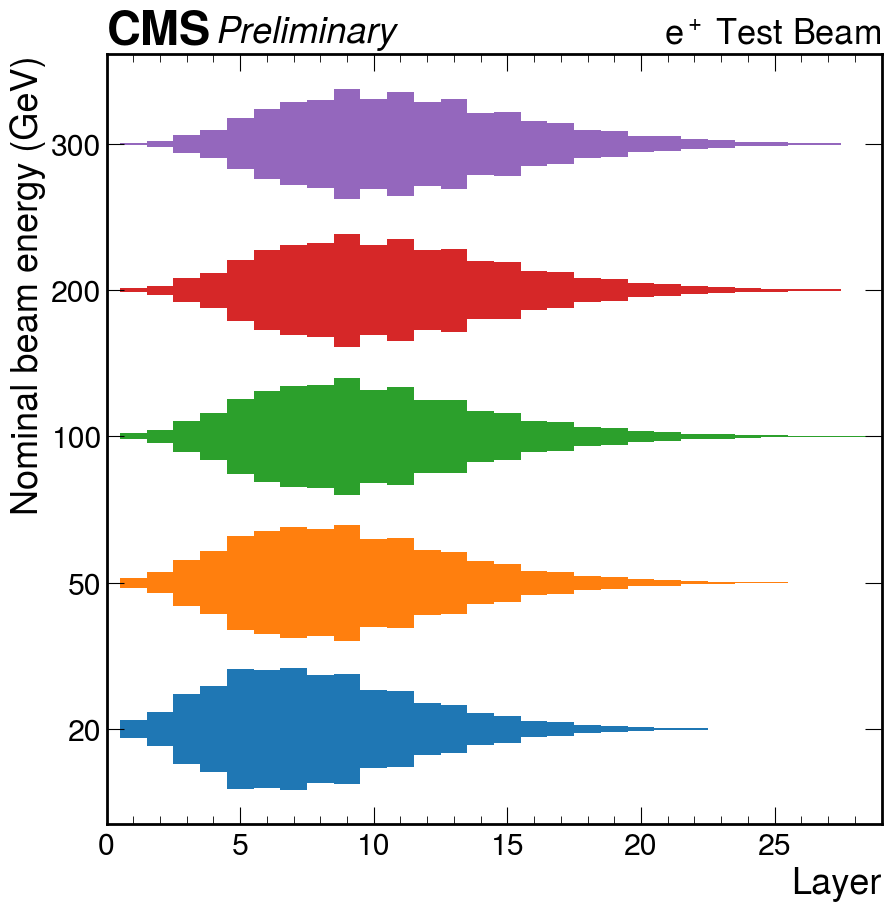

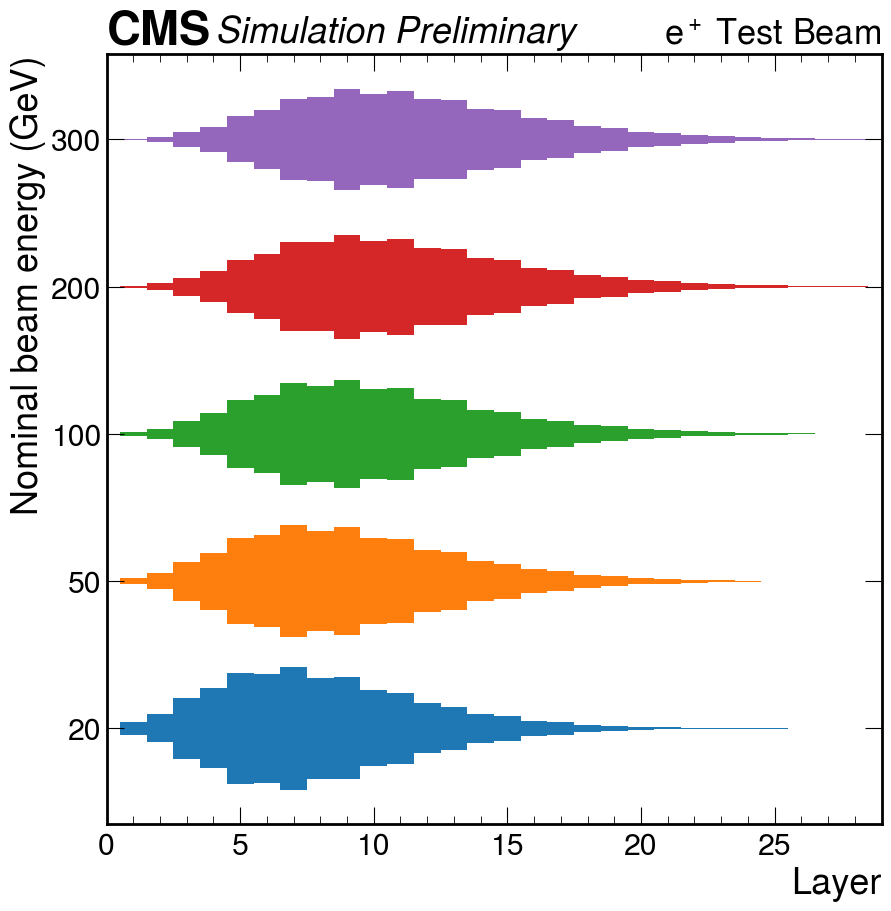

In [7]:
beamEnergiesToPlot = [20, 50, 100, 200, 300]
makeViolinBeamEnergy_wrapper("data", beamEnergies=beamEnergiesToPlot)
#plt.savefig("plots/violin-data.pdf", bbox_inches="tight")
makeViolinBeamEnergy_wrapper("sim_proton_v46_patchMIP", beamEnergies=beamEnergiesToPlot)
#plt.savefig("plots/violin-sim.pdf", bbox_inches="tight")

(0.0, 29.0)

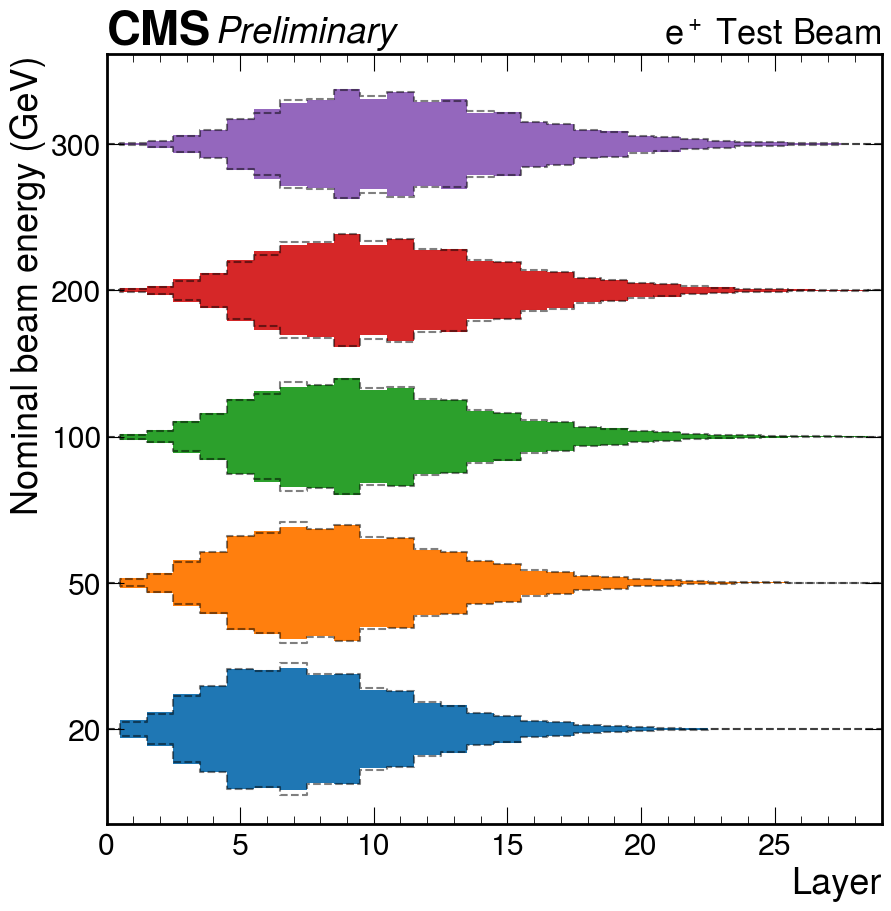

In [11]:
makeViolinBeamEnergyDataSim(getHist("data", beamEnergiesToPlot), getHist("sim_proton_v46_patchMIP", beamEnergiesToPlot))
plt.xlim(0, 29)

In [62]:
def plotKDE(h:hist.Hist, ax, norm=None, **kwargs):
    if norm is None:
        norm = np.sum(h.view().value)
    kde = gaussian_kde(h.axes[0].edges[1:], weights=h.view().value, bw_method=0.25)
    xVals = np.linspace(1, 28, 500)
    ax.plot(xVals, kde(xVals)*norm, **kwargs)

def makeViolinAndProfile(datatype, beamEnergies):
    fig = plt.figure(figsize=(10, 14))
    gs = fig.add_gridspec(2, 1, hspace=0, height_ratios=(2.5, 1))
    violin_ax, profile_ax = gs.subplots(sharex=True)

    hists = getHist(datatype, beamEnergies=beamEnergies)
    makeViolinBeamEnergy(hists, datatype, ax=violin_ax)
    violin_ax.set_xlim(0.5, 28.5)

    for energy, h in hists.items():
        #norm = 1./np.sum(h.view().value)
        norm = 1.
        #profile_ax.plot(h.axes[0].edges[1:], norm*h.view().value, label=f"{energy} GeV")
        kde = gaussian_kde(h.axes[0].edges[1:], weights=norm*h.view().value, bw_method=0.25)
        xVals = np.linspace(1, 28, 500)
        profile_ax.plot(xVals, kde(xVals), label=f"{energy} GeV")
    profile_ax.set_xlabel("Layer")
    profile_ax.set_ylabel("Mean energy on layer\n(smoothed, normalized)")
    profile_ax.legend()
def makeViolinAndProfile_dataSimOverlaid(beamEnergies):
    fig = plt.figure(figsize=(10, 14))
    gs = fig.add_gridspec(2, 1, hspace=0, height_ratios=(2.5, 1))
    violin_ax, profile_ax = gs.subplots(sharex=True)

    hists = getHist("data", beamEnergies=beamEnergies)
    hists_sim = getHist("sim_proton_v46_patchMIP", beamEnergiesToPlot)
    makeViolinBeamEnergyDataSim(hists, hists_sim, ax=violin_ax)
    violin_ax.set_xlim(0.5, 28.5)
    violin_ax.set_ylim(top=0.63)
    handles, labels = violin_ax.get_legend_handles_labels()
    order = [1, 0]
    violin_ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order], loc="upper right")

    for (energy, h), h_sim in zip(hists.items(), hists_sim.values()):
        #norm = 1./np.sum(h.view().value)
        norm = 1.
        #profile_ax.plot(h.axes[0].edges[1:], norm*h.view().value, label=f"{energy} GeV")
        plotKDE(h_sim, ax=profile_ax, norm=norm, linestyle="--", color="black", alpha=0.4)
        plotKDE(h, ax=profile_ax, norm=norm, label=f"{energy} GeV")
        
    profile_ax.set_xlabel("Layer")
    profile_ax.set_ylabel("Mean energy on layer\n(smoothed, normalized)")
    profile_ax.legend()

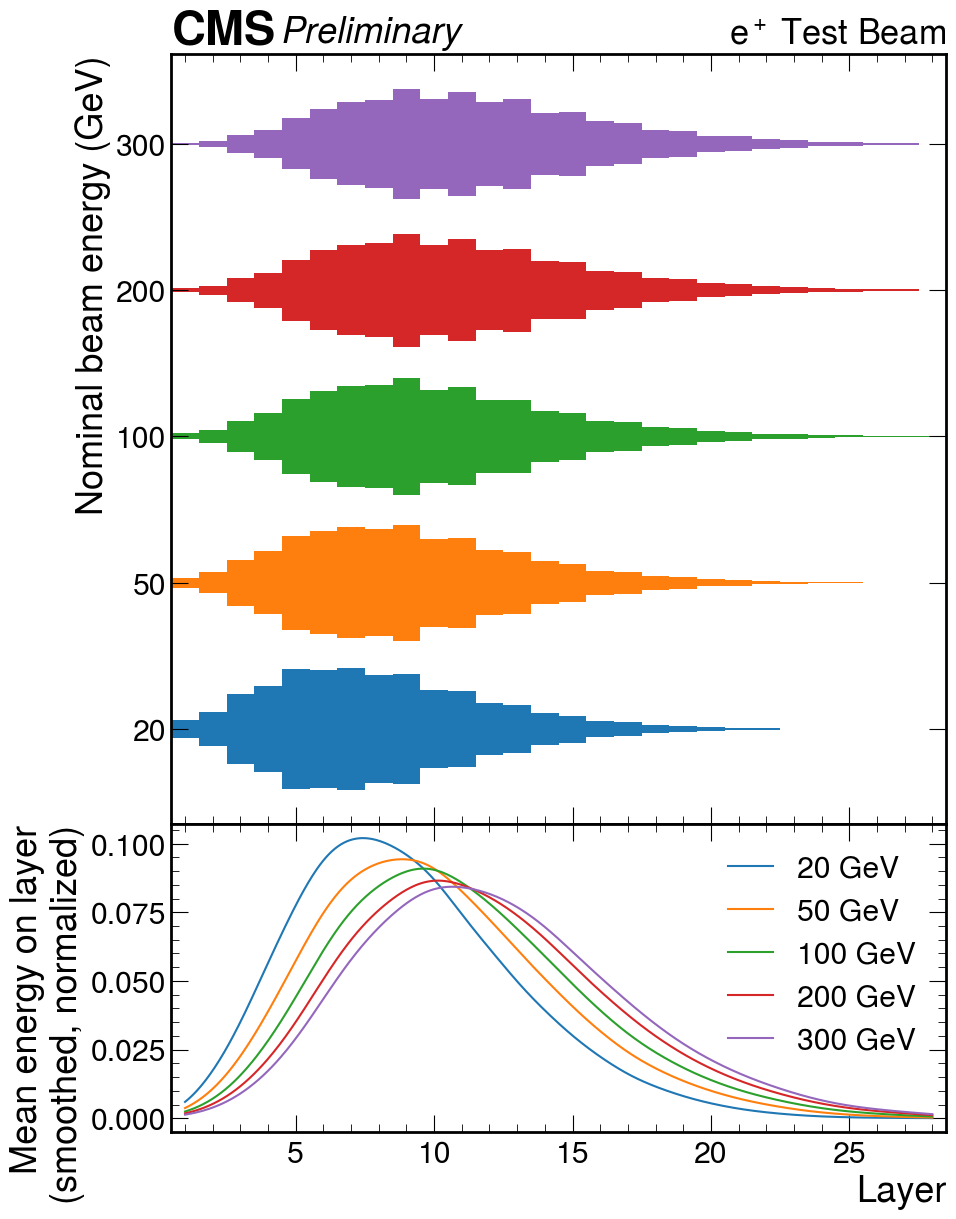

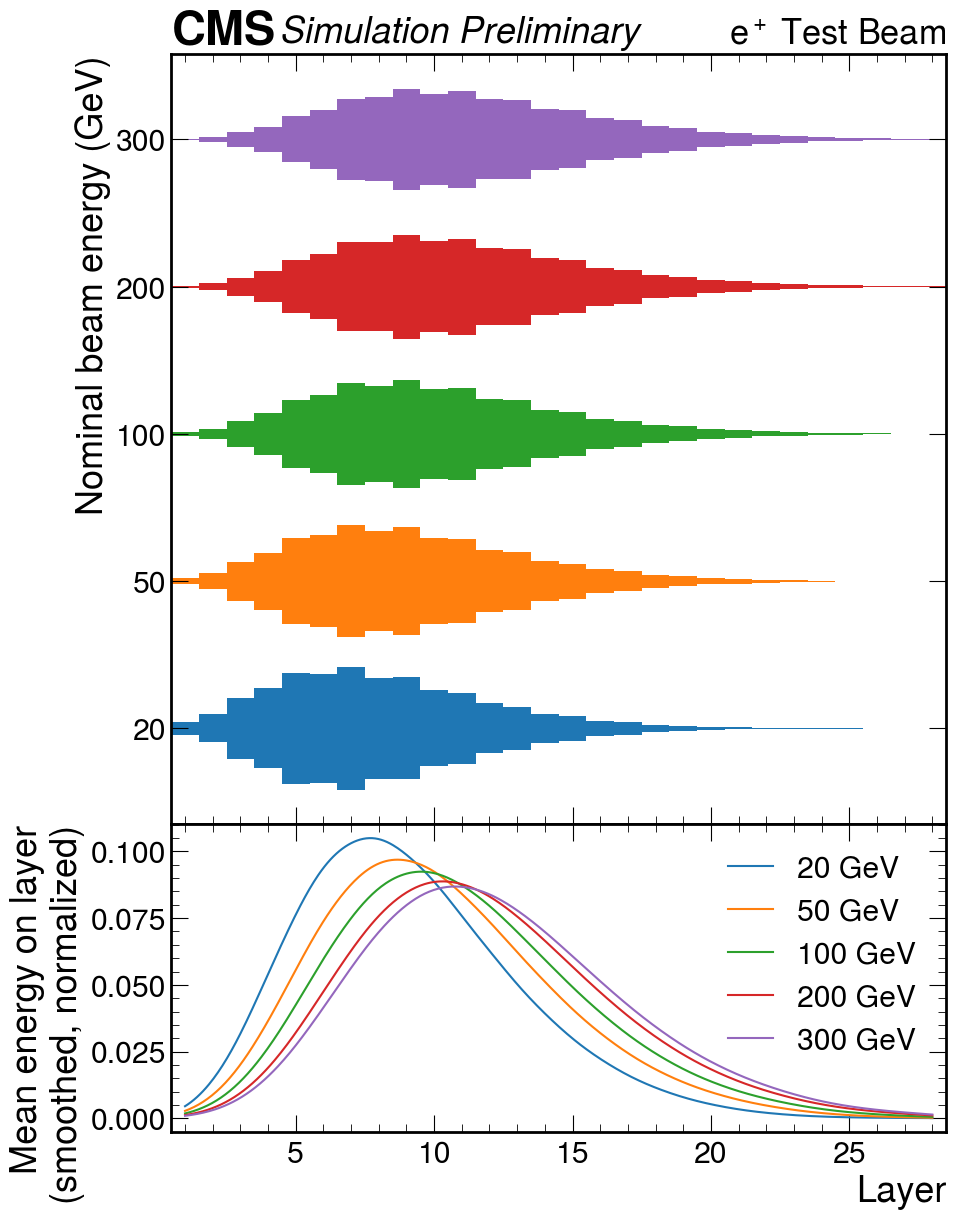

In [17]:
makeViolinAndProfile("data", beamEnergiesToPlot)
plt.savefig("plots/violin-profile-data.pdf", bbox_inches="tight")
makeViolinAndProfile("sim_proton_v46_patchMIP", beamEnergiesToPlot)
plt.savefig("plots/violin-profile-sim.pdf", bbox_inches="tight")

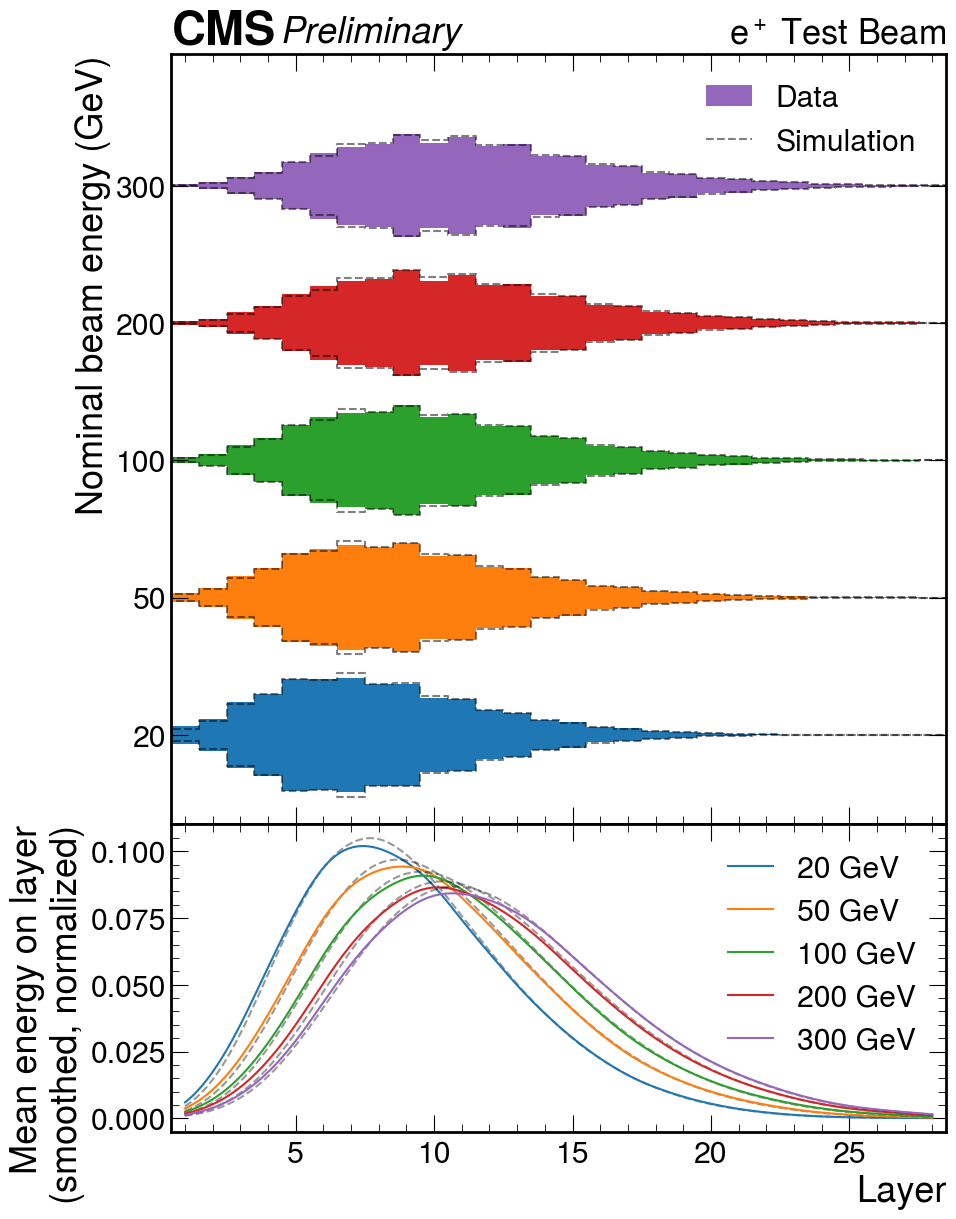

In [69]:
makeViolinAndProfile_dataSimOverlaid(beamEnergiesToPlot)
plt.savefig("plots/violin-profile-datasim.pdf", bbox_inches="tight")

In [ ]:
def makeCompRechitsClue(datatype):
    pass

In [22]:
h_rechits.view().value

array([0.        , 0.54365753, 1.17190672, 2.73409716, 3.98508211,
       6.41905005, 7.79711285, 8.54470859, 8.80048115, 9.95437787,
       7.90968663, 8.40093527, 6.3804481 , 6.32628412, 4.5206674 ,
       4.24678918, 2.81119663, 2.63710281, 1.7625433 , 1.58265306,
       1.01805964, 0.93215553, 0.58605053, 0.46637194, 0.28752741,
       0.26383779, 0.16229041, 0.14207929, 0.04664134, 0.        ])

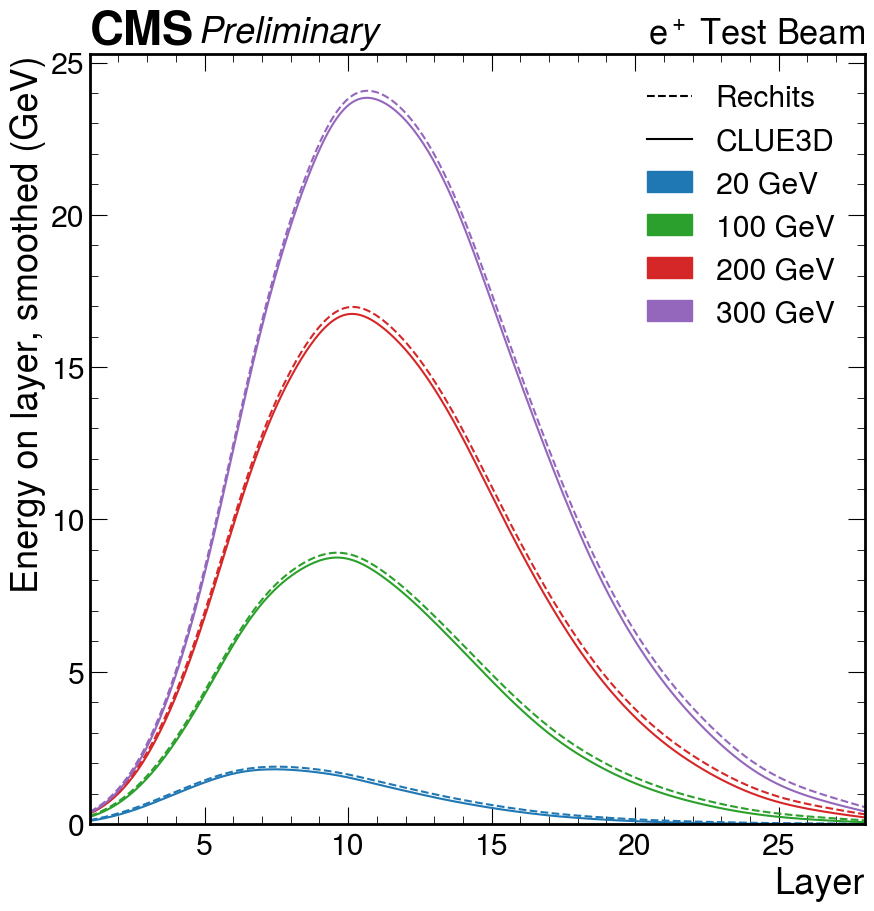

In [70]:
beamEnergiesToPlot_comp = [20., 100., 200., 300.]
colors = ["tab:blue", "tab:green", "tab:red", "tab:purple"]
datatype = "data"
fig, ax = plt.subplots(figsize=(10, 10))
h_rechits = getHist(datatype, beamEnergiesToPlot_comp, "rechits")
h_clue3d = getHist(datatype, beamEnergiesToPlot_comp, "clue3d")

import matplotlib.patches as mpatches
import matplotlib.lines as mlines
legend_handes = [mlines.Line2D([], [], color='black', linestyle="--", label='Rechits'),
                 mlines.Line2D([], [], color='black', label='CLUE3D')]
for (beamEnergy, h_rec), h_cl, color in zip(h_rechits.items(), h_clue3d.values(), colors):
    plotKDE(h_rec,  ax=ax, linestyle="--", color=color)
    plotKDE(h_cl, ax=ax, color=color)
    legend_handes.append(mpatches.Patch(color=color, label=f"{int(beamEnergy)} GeV"))


ax.set_xlim(1, 28)
ax.set_xlabel("Layer")
ax.set_ylim(bottom=0)
ax.set_ylabel("Energy on layer, smoothed (GeV)")
ax.legend(handles=legend_handes)
hep.cms.text("Preliminary", ax=ax)
hep.cms.lumitext("$e^+$ Test Beam", ax=ax)
plt.savefig("plots/rechits-clue-comparison.pdf", bbox_inches="tight")